Environment Configuration
- Start Dolphin
- Load save state f1
- in the worst case scenario set it up manually player1=ash player2=gary

1. Imports Versioning

In [1]:
import gymnasium as gym
import matplotlib
import torch
import torchvision
import torchaudio
import pyautogui
import numpy as np

print(gym.__version__)          # 0.29.1
print(matplotlib.__version__)   # 3.9.2
print(torch.__version__)        # 2.4.1+cpu
print(torchvision.__version__)  # 0.19.1+cpu
print(torchaudio.__version__)   # 2.4.1+cpu
print(pyautogui.__version__)    # 0.9.54
print(np.__version__)           # 1.26.4

0.29.1
3.9.2
2.4.1+cpu
0.19.1+cpu
2.4.1+cpu
0.9.54
1.26.4


2. Initialise Environment, Model & Agent

In [2]:
from DQNCNNAveragePooling import DQNCNN
from DQNAgent import DQNAgent
from PPLEnv import PPLEnv

# States
P1_CELL_BBOX_PJ64 = (348, 130, 830, 1004)
P1_CELL_BBOX_DOLPHIN = (390, 160, 845, 960)

env = PPLEnv(state_bbox=P1_CELL_BBOX_DOLPHIN, color_mode='color')
deep_q_learning_model = DQNCNN(action_size=env.action_space.n)
agent = DQNAgent(deep_q_learning_model, action_size=env.action_space.n)
env.action_space.n

5

3. Training Loop

In [5]:
from helper import alt_tab
import time
import keyboard

# Training loop
num_episodes = 3
agent.q_network.train()
agent.epsilon = 1.0
episode_scores = []

alt_tab() # alt tab to the game
for e in range(num_episodes):
    # Reset the environment and get the initial state (stacked frames managed by PPLEnv)
    state, _ = env.reset()  # Initial state, includes stacked frames
    done = False
    
    while not done:
        # Use the state directly as the stacked frames (already handled by PPLEnv)
        action = agent.select_action(state)  # Select action (can be exploration or exploitation)
        
        # Perform the action in the environment and get the next state and reward
        next_state, reward, done, _, _ = env.step(action)

        # Store experience in replay 
        agent.memory.add((state, action, reward, next_state, done))

        # Train the agent with experience replay
        agent.replay()

        # Update the state (stacked frames already handled by PPLEnv)
        state = next_state  # Update to the new state (stacked frame after the action)
        

        # Periodically update target network
        if e % agent.update_frequency == 0:
            agent.update_target_network()

    print(f"Episode: {e+1}/{num_episodes}, Total Reward: {env.episode_score}")
    episode_scores.append(env.episode_score)
env.close()         
alt_tab() # alt tab out the game
print(f"Highest Score: {max(episode_scores)}")

state shape: (64, 3, 60, 60)
Shape after pooling: torch.Size([64, 3, 12, 6])
Shape after flattening: torch.Size([64, 216])
q_values: tensor([[2.5098, 2.6084, 2.7086, 2.7665, 2.6565],
        [2.4390, 2.6628, 2.5021, 2.6694, 2.5635],
        [2.8311, 2.6964, 2.7631, 3.2727, 3.1105],
        [2.6325, 2.8417, 2.7454, 2.7510, 2.7260],
        [2.5966, 2.7845, 2.7391, 2.7622, 2.6967],
        [2.7904, 2.6864, 2.7693, 3.3309, 3.0862],
        [2.3836, 2.7116, 2.5952, 2.6772, 2.7295],
        [2.5638, 2.7199, 2.5211, 2.7493, 2.7229],
        [2.4636, 2.8045, 2.6343, 2.7057, 2.5045],
        [2.4763, 2.6904, 2.6358, 2.6438, 2.5076],
        [2.3254, 2.5886, 2.5023, 2.5491, 2.4936],
        [2.3659, 2.5580, 2.5878, 2.6320, 2.4770],
        [2.6380, 2.6784, 2.6663, 2.6672, 2.5167],
        [2.9159, 3.1560, 2.7288, 2.8833, 2.7159],
        [2.6591, 2.8481, 2.6476, 2.8218, 2.8271],
        [2.5556, 2.7493, 2.5878, 2.7519, 2.8016],
        [2.6147, 2.7287, 2.6637, 2.8372, 2.7686],
        [2.3426, 

4. Save Model

In [21]:
torch.save(agent.q_network.state_dict(), "dqn_model-v3_lv8_f2_1150.pth")
print("Model saved!")

Model saved!


5. Load Model

In [5]:
agent.q_network = DQNCNN(action_size=ACTION_SIZE, channels=3)
agent.q_network.load_state_dict(torch.load("dqn_model-v3_lv8_f2_160.pth"))

C:\Users\Kaan\AppData\Local\Temp\ipykernel_2156\2897191925.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_network.load_state_dict(torch.load("dqn_model-v3_lv8_f

<All keys matched successfully>

6. Test Loop

In [6]:
import time
import keyboard
from helper import alt_tab
import matplotlib.pyplot as plt

# Test loop
num_test_episodes = 1  # Number of test episodes
alt_tab()  # Bring the game window to the foreground

# Set agent to evaluation mode
agent.q_network.eval()
agent.epsilon = 0.0  # Ensure no exploration during testing (greedy policy)

for e in range(num_test_episodes):
    # Reset the environment and get the initial state
    state, _ = env.reset()
    done = False
    
    while not done:
        # Select the best action based on the current policy
        action = agent.select_action(state, explore=False)
        
        # Perform the action in the environment and get the next state and reward
        next_state, reward, done, _, _ = env.step(action)
        
        # Update the state
        state = next_state
    
    print(f"Test Episode: {e+1}/{num_test_episodes}, Total Reward: {env.episode_score}")

env.close()
alt_tab()


Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Size([1, 216])
Shape after pooling: torch.Size([1, 3, 12, 6])
Shape after flattening: torch.Siz

# Results
Reward +1 for surviving a frame
- on average suvrives for 10 seconds without training
- on average survives for 30 seconds after some  (500 eps)

# You are entering the kitchen

Original Image

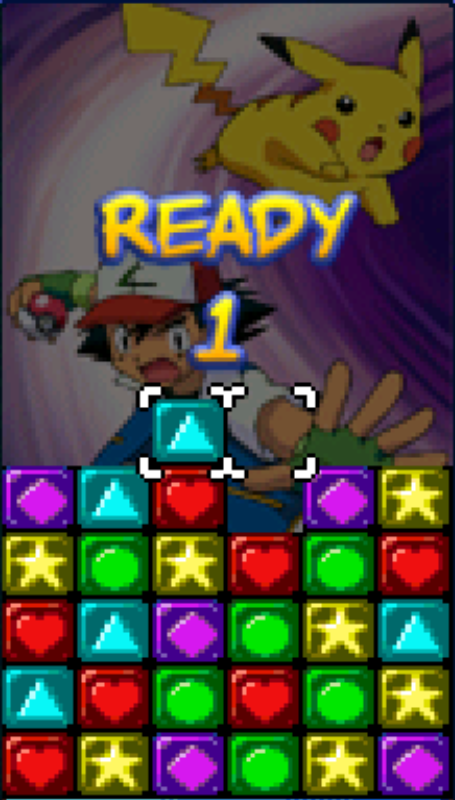

In [4]:
env.screenshot_history[0]

Preprocessed Image (Agent Input)

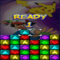

In [5]:
from helper import tensor_to_pil

tensor_to_pil(env.preprocessed_screenshot_history[0])

Agent Output

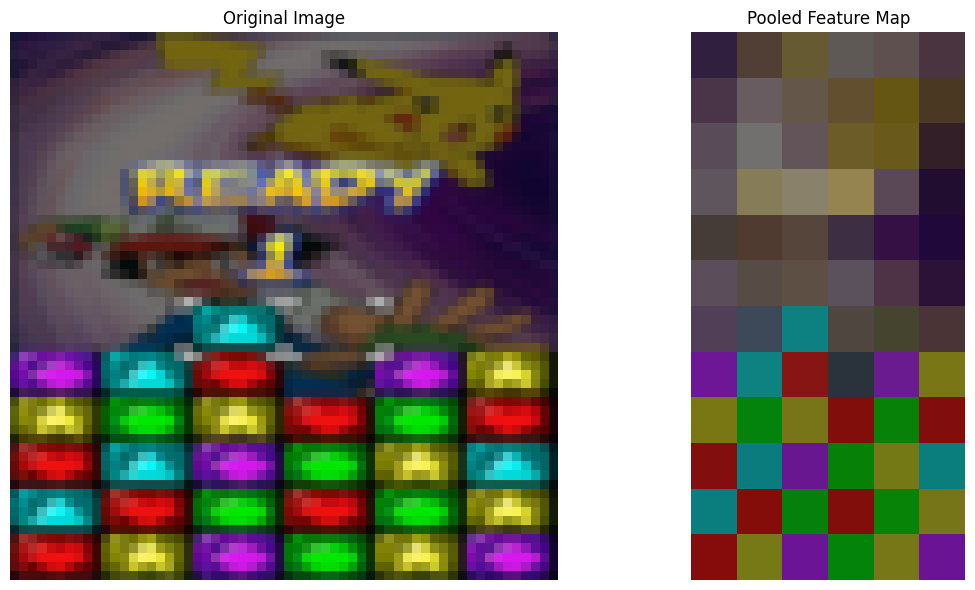

In [6]:
import matplotlib.pyplot as plt

input_img = env.preprocessed_screenshot_history[0].unsqueeze(0)
pooled_output = agent.q_network.check_pooling(input_img)
input_image_np = input_img.squeeze(0).permute(1, 2, 0).detach().numpy()  # Shape: (60, 60, 3)
pooled_output_np = pooled_output.squeeze(0).detach().numpy()
pooled_output_np


# Plot the original image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
ax[0].imshow(input_image_np)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Normalize pooled output to visualize better
# Here, we simply scale the pooled output to [0, 1] for better visualization
pooled_output_normalized = np.clip(pooled_output_np, 0, 1)  # Clip values to be within [0, 1]

# Plot pooled feature map (you can plot individual channels or the entire map)
ax[1].imshow(pooled_output_normalized.transpose(1, 2, 0))  # Shape: (6, 12, 3)
ax[1].set_title("Pooled Feature Map")
ax[1].axis('off')

plt.tight_layout()
plt.show()

### Read Memory

In [4]:
import ctypes
import psutil

# now read the adres

# Constants
PROCESS_ALL_ACCESS = 0x1F0FFF

# Function to get the process ID
def get_process_id(process_name):
    for proc in psutil.process_iter(['pid', 'name']):
        if proc.info['name'] == process_name:
            return proc.info['pid']
    return None

# Function to read memory from a given process at a specific address
def read_memory(process_handle, address, data_type=ctypes.c_uint64):
    value = data_type()
    bytes_read = ctypes.c_size_t()
    result = ctypes.windll.kernel32.ReadProcessMemory(process_handle,ctypes.c_void_p(address),ctypes.byref(value),ctypes.sizeof(value),ctypes.byref(bytes_read))
    if result:
        return value.value
    else:
        error_code = ctypes.GetLastError()
        print(f"Failed to read memory. Error code: {error_code}")
        return None

# Main validation
process_name = "DolphinMemoryEngine.exe"
process_id = get_process_id(process_name)

# Open the process
process_handle = ctypes.windll.kernel32.OpenProcess(PROCESS_ALL_ACCESS, False, process_id)
if process_handle:
    # base_address = 0x7FF9E8A90000 # Qt6Gui.dll
    # base_offset = 0x006EA868
    # offsets = [0xC38, 0x190, 0x750]
    base_address = 0x7FFA08340000 #"Qt6Gui.dll" 7FFA08340000 - Qt6Gui.dll
    base_offset = 0x006EB448
    offsets = [0x80, 0xE30]

    first_pointer = base_address + base_offset
    dereferenced_address  = read_memory(process_handle, first_pointer, data_type=ctypes.c_uint64)
    dereferenced_address_hex = (hex(dereferenced_address))
    print(dereferenced_address_hex)

    for offset in offsets:
        pointer = dereferenced_address + offset
        print(f'Pointer Addre: {hex(pointer)}')
        dereferenced_address  = read_memory(process_handle, pointer)
        print(f'Address Value: {dereferenced_address}')
        dereferenced_address_hex = (hex(dereferenced_address))
        print(dereferenced_address_hex)
a = read_memory(process_handle, pointer, data_type=ctypes.c_uint32)
print(a)

0x1ceb8d6f4f0
Pointer Addre: 0x1ceb8d6f570
Address Value: 1987326715008
0x1ceb5e72480
Pointer Addre: 0x1ceb5e732b0
Address Value: 523
0x20b
523


In [ ]:
process_name = "DolphinMemoryEngine.exe"
process_id = get_process_id(process_name)
base_address = 0x7FF9E8A90000 # Qt6Gui.dll
base_offset = 0x006EA868
offsets = [0xC38, 0x190, 0x750]

first_pointer = base_address + base_offset
dereferenced_address  = read_memory(process_handle, first_pointer, data_type=ctypes.c_uint64)
dereferenced_address_hex = (hex(dereferenced_address))

for offset in offsets:
    pointer = dereferenced_address + offset
    dereferenced_address  = read_memory(process_handle, pointer)
    dereferenced_address_hex = (hex(dereferenced_address))

read_memory(process_handle, pointer, data_type=ctypes.c_uint32)


0.0


### Getting Pixel Color

In [5]:
import pyautogui
from PIL import ImageGrab

# Coordinates of the pixel (x, y)
x, y = 100, 150  # Example coordinates (100, 150)

# Capture the screen at a single pixel location
screenshot = ImageGrab.grab(bbox=(x, y, x+1, y+1))  # Captures a 1x1 pixel region

# Get the color of the pixel at (x, y)
pixel_color = screenshot.getpixel((0, 0))  # (0, 0) because it's a 1x1 region

# Print the color
print(f"The color of the pixel at ({x}, {y}) is: {pixel_color}")

The color of the pixel at (100, 150) is: (24, 24, 24)


In [26]:
import pyautogui
from PIL import ImageGrab, ImageDraw

# Coordinates of the pixel (x, y)
x, y = 400, 965  # Example coordinates (100, 150)

# Capture the screen at a single pixel location
alt_tab()
range=40
screenshot = ImageGrab.grab(bbox=(400, 965, 440, 1005))  # 10x10 region centered on the pixel

# Show the screenshot with the red circle
screenshot.show()

# Get the color of the pixel at (x, y)
pixel_color = screenshot.getpixel((3, 3))  # The pixel is at the center of the 10x10 region

# Print the color
print(f"The color of the pixel at ({x}, {y}) is: {pixel_color}")
alt_tab()

The color of the pixel at (400, 965) is: (75, 89, 190)


### Visualize what the model sees

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import deque

# Example deque of tensors (you can replace this with env.preprocessed_screenshot_history)
# For demonstration, let's assume the frames deque contains tensors
# frames = deque([torch.randn(3, 64, 64) for _ in range(5)])  # Replace with your actual deque

frames = env.preprocessed_screenshot_history

# Loop through the deque and visualize each tensor
for i, frame in enumerate(frames):
    # Ensure the tensor is detached and moved to CPU, if necessary
    frame = frame.detach().cpu() if frame.requires_grad else frame.cpu()

    # Convert the tensor to a NumPy array
    image_array = frame.numpy()

    # Check if the image has 3 channels; if not, handle it
    if image_array.shape[0] == 1:  # Single-channel grayscale
        image_array = image_array[0]  # Squeeze the channel dimension
    else:
        # Rearrange dimensions from [C, H, W] to [H, W, C] for RGB visualization
        image_array = np.transpose(image_array, (1, 2, 0))

    # Normalize or clip the array values to [0, 1] if necessary
    if image_array.max() > 1:
        image_array = image_array / 255.0

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
    plt.title(f"Image {i + 1}")
    plt.axis("off")
    plt.show()
